<a href="https://colab.research.google.com/github/abarrenos/Computational_Biology_UPM/blob/main/Machine_Learning/Supervised_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the data

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
df = pd.read_csv("./drive/MyDrive/files/ML_dataset2.csv", index_col=0)
df.columns = ["target"] + [f"SNP_{i}" for i in range(df.shape[1]-1)]
print("Dataframe dimensions:", df.shape, "\n")
df.head()

Dataframe dimensions: (53, 22) 



,target,SNP_0,SNP_1,SNP_2,SNP_3,SNP_4,SNP_5,SNP_6,SNP_7,SNP_8,...,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,SNP_16,SNP_17,SNP_18,SNP_19,SNP_20
0,R,0,2,2,0,1,2,0,1,0,...,2,0,1,1,0,2,2,1,0,2
1,R,1,2,1,0,0,2,1,2,0,...,0,1,2,0,2,2,1,0,1,1
2,R,1,2,2,1,0,0,2,1,1,...,2,1,2,2,0,0,0,0,0,0
3,R,0,2,0,1,1,0,1,0,1,...,2,0,0,1,0,2,2,0,1,0
4,R,0,0,2,0,0,2,0,1,1,...,1,0,0,0,0,2,1,1,1,1


## Data Preprocessing


The dataset contains 53 individuals (rows), 21 categorical features associated to different SNPs, and 1 target feature (‘Target’). The values of the data represent Mutant/Wild alleles detected in each each individual for the different genes.

In order to make the data suitable for Machine Learning models, these categories have already been transformed to 0 for ‘*MM*’, 1 for ‘*WW*’, 2 for ‘*WM*’, and 3 for ‘*MW*’. Since these categories are not ordinal, they do not have a natural order or ranking, we need to transform them using One Hot Encoder (OHE). OHE transforms the different categories into non-ranked binary arrays (dummy variables).

Moreover, I will also transform 'Target' catergorical feature from String to Integer format using LabelEncoder -1 for *R* and 0 for *NR*-, this will make it suitable for building the model.

In [3]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Convert data to to array
snps = np.array(df)[:,1:]
target = np.array(df)[:,0]

# One Hot Encoding
oh_enc = OneHotEncoder()
lab_enc = LabelEncoder()
ohe_snps = oh_enc.fit_transform(snps).toarray()
label_target = lab_enc.fit_transform(target)

print("Target:\n", label_target)
print("\nSNPs:\n", ohe_snps)

Target:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0]

SNPs:
 [[1. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]]


## Build the Clustering Models

After processing, I will perform a comparative study using the different machine learning classifiers (Logistic Regression, Decision Trees, KNN, Random Forest, and Multilayer Perceptron) aiming to obtain the best possible model for response prediction. 

In order to evaluate the performance of the different parameter combinations for every model, I will conduct a multimetric score cross validation in which different scorers will be calculated. Specifically, I will calculate the values of *'F1 score'*, *'Precision'* and *'Recall'* metrics, even though only the *'F1 score'* -the harmonic mean of Rrecision and Recall- between will be considered to select the optimal model in each Cross Validation process.

I first split the data into training + validation subset (90%) and test subset (10%). Since there are only 47 observations within the training + validation data set, I will carry out a 20-fold cross validation to obtain statistically significant results and avoid overfitting.



In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(ohe_snps, label_target, train_size=0.9, random_state=0)

print("X train:", X_train.shape, "\tX test:", X_test.shape, "\nY train:", Y_train.shape, "\t\tY test:", Y_test.shape)

X train: (47, 67) 	X test: (6, 67) 
Y train: (47,) 		Y test: (6,)


In [5]:
from sklearn.metrics import SCORERS
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
import matplotlib.pyplot as plt

print("Available scores:", sorted(SCORERS.keys()))
scores = {"F1 score": "f1", "Precision": "precision", "Recall": "recall", "Accuracy": "accuracy"}

# Create a function that returns the result of the Cross Validation
def print_cv_results(model):
  print("Best Parameters:", model.best_params_, "\n")
  print("Mean F1 Score:", model.cv_results_['mean_test_F1 score'][model.best_index_].round(3), "\tSD:",      # Best model's F1 Score
                          model.cv_results_['std_test_F1 score'][model.best_index_].round(3))    
  print("Mean Precision:", model.cv_results_['mean_test_Precision'][model.best_index_].round(3), "\tSD:",    # Best model's Precision
                           model.cv_results_['std_test_Precision'][model.best_index_].round(3))    
  print("Mean Recall:", model.cv_results_['mean_test_Recall'][model.best_index_].round(3), "\tSD:",          # Best model's Recall
                        model.cv_results_['std_test_Recall'][model.best_index_].round(3))    
  print("Mean Accuracy:", model.cv_results_['mean_test_Accuracy'][model.best_index_].round(3), "\tSD:",      # Best model's F1 Score
                          model.cv_results_['std_test_Accuracy'][model.best_index_].round(3))    

Available scores: ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 'v_

###  Logistic Regression Classifier

\begin{split}\begin{aligned}
\text{Log Loss} = \sum_{(x,y)\in D} -y\log(y') - (1 - y)\log(1 - y')
\end{aligned}\end{split}
</br>

The **gradient descent** is an iterative algorithm used to identify the weights and intercepts for each feature that minimize the Loss function. I set maximimum number of 500 iterations and a tolerance of 1e-4, that is, the maximal difference between iterations required to achieve convergence. For this classification problem, I decided to set *'liblinear'* algorithm as a solver for the logistic model, since is the most appropriate for small datasets. Moreover, I will compare the performance of the two main regulatization methods supported by *'liblinear'* solver: least absolute error (*L1*) and least squares error (*L2*). (https://medium.com/@aditya97p/l1-and-l2-regularization-237438a9caa6)


The parameter **C** is an important measure that corresponds to the inverse of the regularization strength (*C = 1/α*), which modulates the learning capacity of the model. Low C values could make the Loss Function reach values close to 0 rapidly, thus overfitting the model. In contrast, to large C values would reduce significantly the learning capacity of our model.


In [6]:
import warnings       # Do not print warnings to reduce the output size
warnings.filterwarnings("ignore")

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from time import time   # Import module to measure time cost

logreg = LogisticRegression(solver = "liblinear", max_iter = 500, tol = 1e-4)
lr_param = {'penalty':['l1','l2'], 
            'C':[0.1, 1, 10, 100, 500], 
           }

lr_cv = GridSearchCV(estimator = logreg, param_grid = lr_param, cv = 20, scoring = scores, refit = "F1 score")  # Best model is calculated based on F1 score.
st=time(); lr_cv.fit(X_train, Y_train); et=time()

### ------------------ Print Results --------------------- ###
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
import matplotlib.pyplot as plt
print("Logistic Regression Classifier\n"
      "------------------------------")
print_cv_results(lr_cv)
print("Cross-Validation Time Cost: 0.74s")#+str(round(et-st, 2))+"s")


Logistic Regression Classifier
------------------------------
Best Parameters: {'C': 0.1, 'penalty': 'l2'} 

Mean F1 Score: 0.867 	SD: 0.245
Mean Precision: 0.875 	SD: 0.268
Mean Recall: 0.9 	SD: 0.255
Mean Accuracy: 0.867 	SD: 0.208
Cross-Validation Time Cost: 0.74s


In [10]:
coef = lr_cv.best_estimator_.coef_[0]
coef_idx = list(reversed(abs(coef).argsort()))

col_names = pd.get_dummies(df.drop("target", axis=1), columns = df.drop("target", axis=1).columns).columns    # Get feature names
pd.DataFrame(np.array([col_names[coef_idx], coef[coef_idx]]).T, columns=["Feature (SNP)","Weight"]).head(10).T

,0,1,2,3,4,5,6,7,8,9
Feature (SNP),SNP_11_2,SNP_0_0,SNP_13_0,SNP_11_0,SNP_4_1,SNP_15_2,SNP_4_2,SNP_15_0,SNP_20_0,SNP_13_2
Weight,-0.292921,0.287571,0.274083,0.249412,0.231077,-0.227391,-0.223308,0.211355,0.192868,-0.186892


### K-Nearest Kneighbors Classifier

K-Nearest Kneighbors (KNN) is a classification and regression method that can be used to classify input data points based on the class to which the K-nearest neighboring points belong to. I will train the model using different algorithms to identify the nearest neighbors -*'auto', 'ball_tree', 'kd_tree', 'brute'*- and  based on the nature and scale of the data, I decided that distant-based (geometric) methods, rather that similarity-based, are more suitable for this problem.

Tree-based algorithms to find neighboring points aim to be more efficient than brute force for large datasets (not in this case) and its performance is regulated by the *leaf size*, which ranges from 1 to N for N training points.
(https://scikit-learn.org/stable/modules/neighbors.html#classification)

Perhaps, the most important parameter for KNN model is the number of neighbors to consider (*K*). These neighbors vote to determine the class of the new point, and they can have uniform or different *weights* in the voting process.

In [11]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from time import time 

knn = KNeighborsClassifier()
knn_param = {"n_neighbors": range(1,11),
            "weights": ['uniform', 'distance'], 
            "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
            "leaf_size" : np.arange(1, 43, 10),
            "metric":['euclidean', 'manhattan']
            } 

knn_cv = GridSearchCV(estimator = knn, param_grid = knn_param, cv = 20, scoring = scores, refit="F1 score")
st=time(); knn_cv.fit(X_train, Y_train); et=time()

### ------------- Save Cross-Validation Results to save time ------------- ###
import joblib
# joblib.dump(knn_cv, 'knn_cv_results.pkl')
# knn_cv = joblib.load("knn_cv_results.pkl")

### --------------------- Print Results --------------------- ###
print("K-Nearest Neighbors Classifier\n"
      "------------------------------")
print_cv_results(knn_cv)
print("Cross-Validation Time Cost: 62.96s")#+str(round(et-st, 2))+"s")  # 62.96s


K-Nearest Neighbors Classifier
------------------------------
Best Parameters: {'algorithm': 'ball_tree', 'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'} 

Mean F1 Score: 0.867 	SD: 0.306
Mean Precision: 0.875 	SD: 0.311
Mean Recall: 0.875 	SD: 0.311
Mean Accuracy: 0.892 	SD: 0.225
Cross-Validation Time Cost: 62.96s


Text(0, 0.5, 'F1 Score')

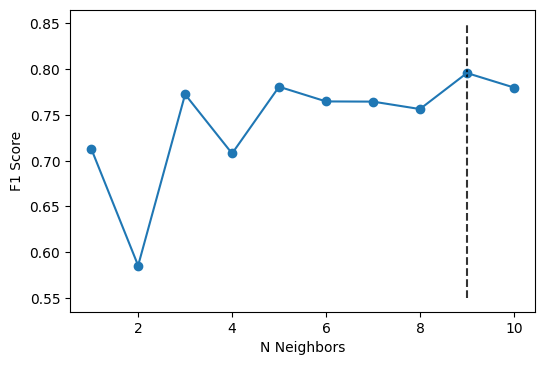

In [51]:
# Analyse the average F1 score for different K Neighbors obtained via Cross Validation
f1_scores=[]
for k in range(1, 11):
  neighbors = np.asarray(knn_cv.cv_results_["param_n_neighbors"])
  indexes = np.where(neighbors == k)[0]
  f1_scores.append(knn_cv.cv_results_["mean_test_F1 score"][indexes].mean())

fig, ax = plt.subplots(dpi = 100)
ax.plot(range(1, 11), f1_scores)
ax.scatter(range(1, 11), f1_scores)
ax.vlines(x=9, ymin=0.55, ymax=0.85, linestyles = "dashed", alpha = 0.8)
ax.set_xlabel("N Neighbors")
ax.set_ylabel("F1 Score")

### Decision Tree Classifier

Decision trees are supervised models that can address classification and regression problems by making simple binary decisions inferred from the data features, generating a **binary tree-like structure**. These models identify the most informative features (*nodes*) that better separate our data into *branches* or final *leaves*. For fine-tuning the model, I will compare the performance of *Gini*, *entropy* and *log_loss* criteria that measure information gain in every split of the tree. Further, I will balance the weights of *R* and *NR* classes to avoid biases in the tree structure.

Decision trees will eventually become overfitted if their growth is not limited and if the size of their leaves is too small (close to one sample per leaf). In contrast, very strict growth restrictions can prevent the tree from learning. To avoid overfitting and ensure learning, I will perform Cross Validation using different *tree depths* -maximum number of consecutive node divisions- and *minimum leaf sizes*. Moreover, I will establish a *minimal impurity decrease* (or information gain) requirement for a node bifurcation to occur to prune the tree.

Another way of controlling overfitting is via pruning of the final leaves to obtain less complex subtrees. The most common method is Cost-Complexity pruning, which is regulated through the parameter *ccp_alpha*. Since I am already limiting tree growth, I will not perform pruning (default).

(https://scikit-learn.org/stable/modules/tree.html#classification)




In [13]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree = DecisionTreeClassifier(class_weight = "balanced", random_state=10, splitter = 'best')   # Choose the best split (most informative) at each node.
tree_param = {'min_samples_leaf': [1, 5, 10],
              'max_depth': [3, 5, 20],
              'min_impurity_decrease':[0.1, 0.2, 0.3],
              'criterion': ['gini', 'entropy', 'log_loss']
              }

tree_cv = GridSearchCV(estimator = tree, param_grid = tree_param, cv = 20, scoring = scores, refit="F1 score")
# st=time(); tree_cv.fit(X_train, Y_train); et=time()

### ------------- Save Cross-Validation Results to save time ------------- ###
# joblib.dump(tree_cv, 'tree_cv_results.pkl')
tree_cv = joblib.load("tree_cv_results.pkl")

### --------------------- Print Results --------------------- ###
print("Decision Tree Classifier\n"
      "-------------------------")
print_cv_results(tree_cv)
print("Cross-Validation Time Cost: 5.33s")#+str(round(et-st, 2))+"s")  


Decision Tree Classifier
-------------------------
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1} 

Mean F1 Score: 0.723 	SD: 0.384
Mean Precision: 0.733 	SD: 0.399
Mean Recall: 0.75 	SD: 0.403
Mean Accuracy: 0.75 	SD: 0.323
Cross-Validation Time Cost: 5.33s


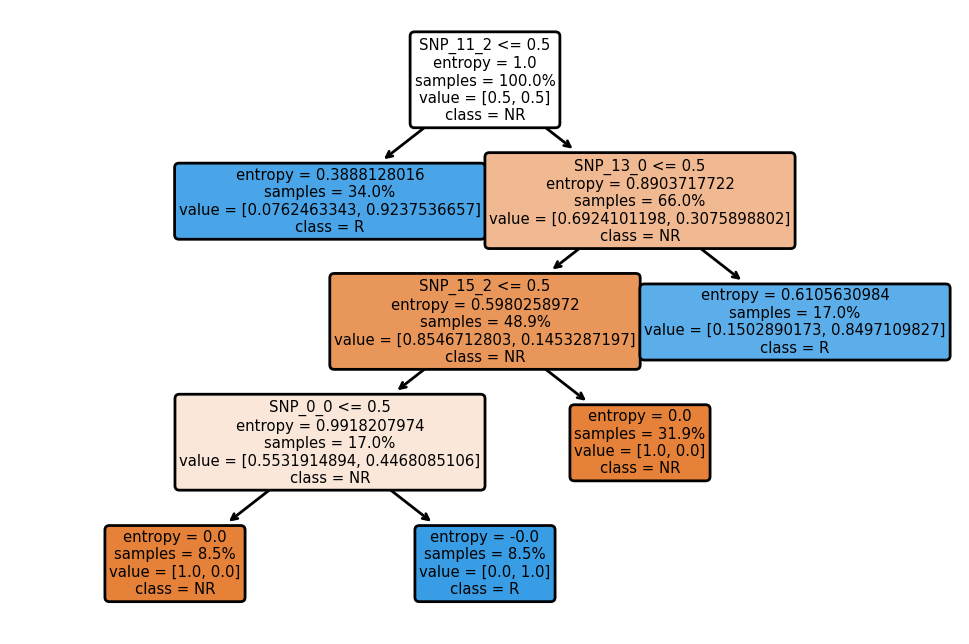

In [14]:
plt.figure(dpi = 200)
plot_tree(tree_cv.best_estimator_, filled = True, proportion = True, rounded = True, class_names=["NR", "R"], feature_names=col_names, precision = 10)
plt.show()

In [15]:
## Feature importances
imp_feat = list(reversed(sorted(tree_cv.best_estimator_.feature_importances_)))
imp_feat_idx = list(reversed(tree_cv.best_estimator_.feature_importances_.argsort()))

pd.DataFrame(np.array([col_names[imp_feat_idx], imp_feat]).T, columns=["Feature (SNP)","Importance"]).head()

,Feature (SNP),Importance
0,SNP_11_2,0.340536
1,SNP_13_0,0.25461
2,SNP_0_0,0.218394
3,SNP_15_2,0.186459
4,SNP_1_0,0.0


## Random Forest Classifier

A Random Forest is an ensemble of multiple individual Decision Trees (weak learners), each of them trained with different subsamples of the training set drawn with replacement to produce variable results. Besides this, we can increase randomness by sampling a subset of features to consider for each individual Decision Tree. The decisions of the individual classifiers are then combined and averaged to improve predictive accuracy and control over-fitting.

The purpose of these two sources of randomness is to decrease the variance of the forest estimator, despite a slight potential increase in bias. Overall, ensembles tackle the main limitations of decision trees: they are more accurate, less prone to over-fitting and more robust (less sensitive to slight variations in data). 

For this model, I will perform subsamplig of training data (*bootstrap sampling*) and features, and assess the accuracy of the ensemble for different maximum numbers of samples and features. The lower the sampling size, the greater the reduction of variance, but also the greater the increase in bias.

Besides the sampling criteria, the most important parameter to define is the number of weak estimators, therefore, I will compare the performance of the model with different number of trees. Finally, I will fine-tune the same hyperparameters as I previously did for the Decision Trees (tree depth, criterion and minimum information gain per split).

https://scikit-learn.org/stable/modules/ensemble.html#

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0, class_weight = "balanced_subsample", bootstrap=True
                             )
rfc_param = { 'n_estimators': [100, 200, 300, 500],
              'max_features': [0.5, 0.8, 1.],
              'max_samples': [0.5, 0.8, 1.],
              'max_depth': [3, 5, 10],
              'min_impurity_decrease': [0.1, 0.2, 0.3],
              'criterion': ['gini', 'entropy', 'log_loss']
            } 

rfc_cv = GridSearchCV(estimator = rfc, param_grid = rfc_param, cv = 20, scoring = scores, refit="F1 score")
st=time(); rfc_cv.fit(X_train, Y_train); et=time()

### ------------- Save Cross-Validation Results to save time ------------- ###
# joblib.dump(rfc_cv, 'rfc_cv_results3_90.pkl')
# rfc_cv = joblib.load("rfc_cv_results.pkl")

### --------------------- Print Results --------------------- ###
print("Random Forest Classifier\n"
      "-------------------------")
print_cv_results(rfc_cv)
print("Cross-Validation Time Cost: 3741.04s")#+str(round(et-st, 2))+"s")  


In [ ]:
# Analyse the average F1 score for different number of weak learners.
f1_scores=[]
for n in [100, 200, 300, 500]:
  trees = np.asarray(rfc_cv.cv_results_["param_n_estimators"])
  indexes = np.where(trees == n)[0]
  f1_scores.append(np.nanmean(rfc_cv.cv_results_["mean_test_F1 score"][indexes]))

fig, ax = plt.subplots(dpi = 100)
ax.plot(list([50, 100, 200, 300]), f1_scores)
ax.scatter(list([50, 100, 200, 300]), f1_scores)
# ax.vlines(x=9, linestyles = "dashed", alpha = 0.8)
ax.set_xlabel("N Neighbors")
ax.set_ylabel("F1 Score")

## Multilayer Perceptron Classifier

Multilayer Perceptrons (MLP) are Supervised Learning Models that aim to simulate the information processing mechanism of the brain. MLPs are formed by multiple layers of neurons, where each neuron is connected to all the neurons in the previous and following layers. The **input layer** represent the training data features, each neuron in the **hidden layer** transforms the values received from the previous layer with a weighted linear summation followed by a non-linear *activation function*, and the **output layer** transforms the values from the last hidden layer into the final output class or feature. In classification problems, the output layer normally applies the softmax function.
(https://en.wikipedia.org/wiki/Softmax_function#Neural_networks)

In MLP models, the parameters of the network (weights
and thresholds) need to be finely-tuned until the output of the network is the closest to the expected output. This is usually performed using the *gradient descent* iterative method, as in logistic models, that minimizes the Loss Function. I will specifically use the *'lbfgs'* algorithm, which is more accurate and faster for small datasets. The learning rate of the model is controlled by the *regularization parameter (α)*, which needs to be properly adjusted to avoid overfitting.

For this problem, I will evaluate the performance of the MLP with different number of hidden layers and neurons, and using diverse non-linear activation functions for the neurons in the hidden layers.

https://scikit-learn.org/stable/modules/neural_networks_supervised.html#



In [17]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver = "lbfgs", max_iter=5000, random_state=0)   # Stop gradient descent after 5000 iterations or until convergence.
mlp_params = {
    'hidden_layer_sizes': [(5, ), (5, 5), (10, ), (10, 10), (50,), (50, 50), (100,), (100, 100)],
    'activation': ['logistic', 'tanh', 'relu'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1]
}
mlp_cv = GridSearchCV(estimator = mlp, param_grid = mlp_params, cv = 20, scoring = scores, refit="F1 score")
# st=time(); mlp_cv.fit(X_train, Y_train); et=time()

### ------------- Save Cross-Validation Results to save time ------------- ###
# joblib.dump(mlp_cv, 'mlp_cv_results.pkl')
mlp_cv = joblib.load("mlp_cv_results.pkl")

### --------------------- Print Results --------------------- ###
print("Multi-Layer Perceptron\n"
      "-------------------------")
print_cv_results(mlp_cv)
print("Cross-Validation Time Cost: 131.74s")#+str(round(et-st, 2))+"s")


Multi-Layer Perceptron
-------------------------
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (5, 5)} 

Mean F1 Score: 0.917 	SD: 0.144
Mean Precision: 0.95 	SD: 0.15
Mean Recall: 0.925 	SD: 0.179
Mean Accuracy: 0.9 	SD: 0.178
Cross-Validation Time Cost: 131.74s


## Generate a table to show the Validation results

In [ ]:
df_cv = pd.DataFrame()

for model in [lr_cv, knn_cv, tree_cv, rfc_cv, mlp_cv]:
  f1 = str(model.cv_results_['mean_test_F1 score'][model.best_index_].round(3)) +" ± "+ str(model.cv_results_['std_test_F1 score'][model.best_index_].round(3))    
  precision = str(model.cv_results_['mean_test_Precision'][model.best_index_].round(3)) +" ± "+ str(model.cv_results_['std_test_Precision'][model.best_index_].round(3))    
  recall = str(model.cv_results_['mean_test_Recall'][model.best_index_].round(3)) +" ± "+ str(model.cv_results_['std_test_Recall'][model.best_index_].round(3))    
  accuracy = str(model.cv_results_['mean_test_Accuracy'][model.best_index_].round(3)) +" ± "+ str(model.cv_results_['std_test_Accuracy'][model.best_index_].round(3))

  df_cv = pd.concat([df_cv, pd.DataFrame.from_dict({"F1 Score":[f1], "Precision":[precision], "Recall":[recall], "Accuracy":[accuracy]})], axis=0)

df_cv.insert(loc=0, column="CV Model", value=["Logistic Regression", "K-Nearest Neighbors", "Decision Tree", "Random Forest", "Multi Layer Perceptron"])
df_cv.reset_index(drop = True, inplace=True)
df_cv


In [ ]:
!pip install dataframe_image && apt install chromium-chromedriver
import dataframe_image as dfi

df_style = df_cv.style.hide_index().highlight_max(subset= df_cv.drop("CV Model", axis=1).columns, color="lightgreen")

df_style.set_table_styles([
    dict(selector="th", props=[
      ('font-size', '13px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('background-color', '#e7eef9')
      ]), 
    ])

dfi.export(df_style, 'Cross_Validation.png', dpi = 200)

In [ ]:
print("\nTest Prediction\n"
        "---------------")
Y_pred = lr_cv.best_estimator_.predict(X_test)    # The best estimator is automatically refitted on the whole train + validation data.

print("F1 Score:", f1_score(Y_test, Y_pred).round(3))
print("Accuracy:", accuracy_score(Y_test, Y_pred).round(3),"\n")
conf = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred), display_labels=["NR", "R"])

fig,ax = plt.subplots(dpi = 80)
ax.set_title("Logistic Classifier")
conf.plot(ax=ax)
#-----------------------------------------------------------------------------

print("\nTest Prediction\n"
        "---------------")
Y_pred = knn_cv.best_estimator_.predict(X_test)    # The best estimator is automatically refitted on the whole train + validation data.

print("F1 Score:", f1_score(Y_test, Y_pred).round(3))
print("Accuracy:", accuracy_score(Y_test, Y_pred).round(3),"\n")
conf = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred), display_labels=["NR", "R"])

fig,ax = plt.subplots(dpi = 80)
ax.set_title("KNN Classifier")
conf.plot(ax=ax)
#-----------------------------------------------------------------------------

print("\nTest Prediction\n"
        "---------------")
Y_pred = tree_cv.best_estimator_.predict(X_test)    # The best estimator is automatically refitted on the whole train + validation data.

print("F1 Score:", f1_score(Y_test, Y_pred).round(3))
print("Accuracy:", accuracy_score(Y_test, Y_pred).round(3),"\n")
conf = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred), display_labels=["NR", "R"])

fig, ax = plt.subplots(1, dpi = 80)
ax.set_title("Decission Tree Classifier")
conf.plot(ax=ax)
#-----------------------------------------------------------------------------

print("\nTest Prediction\n"
        "---------------")
Y_pred = rfc_cv.best_estimator_.predict(X_test)    # The best estimator is automatically refitted on the whole train + validation data.

print("F1 Score:", f1_score(Y_test, Y_pred).round(3))
print("Accuracy:", accuracy_score(Y_test, Y_pred).round(3),"\n")

conf = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred), display_labels=["NR", "R"])
fig, ax = plt.subplots(1, dpi = 80)
ax.set_title("Random Forest Classifier")
conf.plot(ax=ax)
#-----------------------------------------------------------------------------

print("\nTest Prediction\n"
        "---------------")
Y_pred = mlp_cv.best_estimator_.predict(X_test)    # The best estimator is automatically refitted on the whole train + validation data.

print("F1 Score:", f1_score(Y_test, Y_pred).round(3))
print("Accuracy:", accuracy_score(Y_test, Y_pred).round(3),"\n")
conf = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred), display_labels=["NR", "R"])

conf = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred), display_labels=["NR", "R"])
fig, ax = plt.subplots(1, dpi = 80)
ax.set_title("Multi-Layer Perceptron")
conf.plot(ax=ax)